In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install jq
!pip install torchtext==0.6.0
%cd /content/drive/My\ Drive/Colab\ stuff/sensor_anomaly
%ls

Reading package lists... Done
Building dependency tree       
Reading state information... Done
jq is already the newest version (1.5+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
/content/drive/My Drive/Colab stuff/sensor_anomaly
data_aggregation.ipynb    Sensor2Activity.ipynb   tut4-model2-20.pt
dataset/                  Sensor-Activity-20.txt  tut4-model2.pt
deepmind/                 Sensor-Activity.txt     tut4-model.pt
NMT_in_PyTorch.ipynb      STGCN-PyTorch-master/   UAI-master/
preprocessing_data.ipynb  test.csv                val.csv
pytorch-seq2seq-master/   train.csv               venv/


# 4 - Packed Padded Sequences, Masking, Inference and BLEU

## Introduction

In this notebook we will be adding a few improvements - packed padded sequences and masking - to the model from the previous notebook. Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the BLEU metric to measure the quality of our translations.

## Preparing Data

First, we'll import all the modules as before, with the addition of the `matplotlib` modules used for viewing the attention.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext.data
from torchtext.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np

import random
import math
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from torchtext.data.metrics import bleu_score


Next, we'll set the random seed for reproducability.

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

When using packed padded sequences, we need to tell PyTorch how long the actual (non-padded) sequences are. Luckily for us, TorchText's `Field` objects allow us to use the `include_lengths` argument, this will cause our `batch.src` to be a tuple. The first element of the tuple is the same as before, a batch of numericalized source sentence as a tensor, and the second element is the non-padded lengths of each source sentence within the batch.

In [5]:
tokenize_simple = lambda x: x.split()
SRC = Field(tokenize = tokenize_simple, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_simple, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [6]:
f = open('Sensor-Activity-20.txt', encoding='UTF-8').read().strip().split('\n')
lines = f
original_word_pairs = [[w for w in l.split('\t')] for l in lines]
raw_data = {'Sensor' : [line[0] for line in original_word_pairs], 'Activity': [line[1] for line in original_word_pairs]}
df = pd.DataFrame(raw_data, columns=["Sensor", "Activity"])
print(len(df))
train_data, test_data = train_test_split(df, test_size=0.03)
train_data, valid_data = train_test_split(train_data, test_size=0.033)
print(len(train_data), len(test_data), len(valid_data))
train_data.to_csv("train.csv", index=False, header=False)
valid_data.to_csv("val.csv", index=False, header=False)
test_data.to_csv("test.csv", index=False, header=False)
data_fields = [('Sensor', SRC), ('Activity', TRG)]
train_data,valid_data = torchtext.data.TabularDataset.splits(path='./', train='train.csv', validation='val.csv', format='csv', fields=data_fields)
train_data,test_data = torchtext.data.TabularDataset.splits(path='./', train='train.csv', validation='test.csv', format='csv', fields=data_fields)
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")
print(vars(valid_data.examples[700]))
SRC.build_vocab(train_data, valid_data, test_data, min_freq = 1)
TRG.build_vocab(train_data, valid_data, test_data, min_freq = 1)
print(f"Unique tokens in source (sensor) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (activity) vocabulary: {len(TRG.vocab)}")

23766
22292 713 761
Number of training examples: 22292
Number of validation examples: 761
Number of testing examples: 713
{'Sensor': ['1', '63', '1', '1', '2466', '79', '131', '241', '1', '1', '3', '1', '1', '1', '1', '1', '1', '380', '781', '290', '79'], 'Activity': ['135', '135', '135', '135', '99', '154', '154', '154', '154', '154', '154', '154', '154', '154', '154', '154', '154', '154', '154', '154', '154']}
Unique tokens in source (sensor) vocabulary: 4862
Unique tokens in target (activity) vocabulary: 170


## Building the Model

### Encoder

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

The attention module is where we calculate the attention values over the source sentence. 

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [8]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [9]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

Then, we initialize the model parameters.

In [11]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

Next, we'll define our training and evaluation loops.

As we are using `include_lengths = True` for our source field, `batch.src` is now a tuple with the first element being the numericalized tensor representing the sentence and the second element being the lengths of each sentence within the batch.

Our model also returns the attention vectors over the batch of source source sentences for each decoding time-step. We won't use these during the training/evaluation, but we will later for inference.

In [12]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.Sensor
        trg = batch.Activity
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        sched.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [13]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.Sensor
            trg = batch.Activity

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Then, we'll define a useful function for timing how long epochs take.

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source sentence if it has not been tokenized (is a string)
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

In [15]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    # if isinstance(sentence, str):
    #     nlp = spacy.load('de')
    #     tokens = [token.text.lower() for token in nlp(sentence)]
    # else:
    tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [16]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Next, we handle the iterators.

One quirk about packed padded sequences is that all elements in the batch need to be sorted by their non-padded lengths in descending order, i.e. the first sentence in the batch needs to be the longest. We use two arguments of the iterator to handle this, `sort_within_batch` which tells the iterator that the contents of the batch need to be sorted, and `sort_key` a function which tells the iterator how to sort the elements in the batch. Here, we sort by the length of the `src` sentence.

In [18]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.Sensor),
     device = device)

## Training the Seq2Seq Model

Next up, initializing the model and placing it on the GPU.

Then we define our optimizer and criterion. 

The `ignore_index` for the criterion needs to be the index of the pad token for the target language, not the source language.

In [19]:
# Model parameters
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 350
DEC_EMB_DIM = 170
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

# Model Definition
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(init_weights)

# Training parameters
max_lr = 0.01
weight_decay = 1e-4
N_EPOCHS = 100
CLIP = 1
optimizer = optim.Adam(model.parameters(), lr = 1e-4, betas=(0.9, 0.999), weight_decay=weight_decay)
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
steps_per_epoch=len(train_iterator)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=N_EPOCHS, 
                                                steps_per_epoch=steps_per_epoch)

We'll print out the number of trainable parameters in the model, noticing that it has the exact same amount of parameters as the model without these improvements.

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,610,742 trainable parameters


The penultimate step is to train our model. Notice how it takes almost half the time as our model without the improvements added in this notebook.

In [21]:
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print("Learning rate: ", sched.get_lr())

Epoch: 01 | Time: 0m 58s
	Train Loss: 1.777 | Train PPL:   5.914
	 Val. Loss: 2.054 |  Val. PPL:   7.802
Learning rate:  [0.00042630491303872337]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch: 02 | Time: 0m 58s
	Train Loss: 0.729 | Train PPL:   2.073
	 Val. Loss: 2.460 |  Val. PPL:  11.707
Learning rate:  [0.0005049313403007391]
Epoch: 03 | Time: 0m 58s
	Train Loss: 0.545 | Train PPL:   1.724
	 Val. Loss: 2.651 |  Val. PPL:  14.162
Learning rate:  [0.0006350175062311836]
Epoch: 04 | Time: 0m 58s
	Train Loss: 0.522 | Train PPL:   1.686
	 Val. Loss: 2.282 |  Val. PPL:   9.793
Learning rate:  [0.000815137616962414]
Epoch: 05 | Time: 0m 58s
	Train Loss: 0.488 | Train PPL:   1.630
	 Val. Loss: 2.567 |  Val. PPL:  13.021
Learning rate:  [0.001043317487557217]
Epoch: 06 | Time: 0m 58s
	Train Loss: 0.477 | Train PPL:   1.611
	 Val. Loss: 2.336 |  Val. PPL:  10.344
Learning rate:  [0.0013170561798267685]
Epoch: 07 | Time: 0m 58s
	Train Loss: 0.435 | Train PPL:   1.545
	 Val. Loss: 2.014 |  Val. PPL:   7.490
Learning rate:  [0.0016333534135646137]
Epoch: 08 | Time: 0m 58s
	Train Loss: 0.460 | Train PPL:   1.584
	 Val. Loss: 2.283 |  Val. PPL:   9.807
Learning rate:  [0.00198874

In [22]:
torch.save(model.state_dict(), 'tut4-model2-20.pt')

Finally, we load the parameters from our best validation loss and get our results on the test set.

We get the improved test perplexity whilst almost being twice as fast!

In [23]:
model.load_state_dict(torch.load('tut4-model2-20.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.415 | Test PPL:   4.116 |


Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

In [24]:
example_idx = 12

src = vars(train_data.examples[example_idx])['Sensor']
trg = vars(train_data.examples[example_idx])['Activity']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
trg = ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32']


Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

Below is an example the model attempted to translate, it gets the translation correct except changes *are fighting* to just *fighting*.

In [25]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '<eos>']


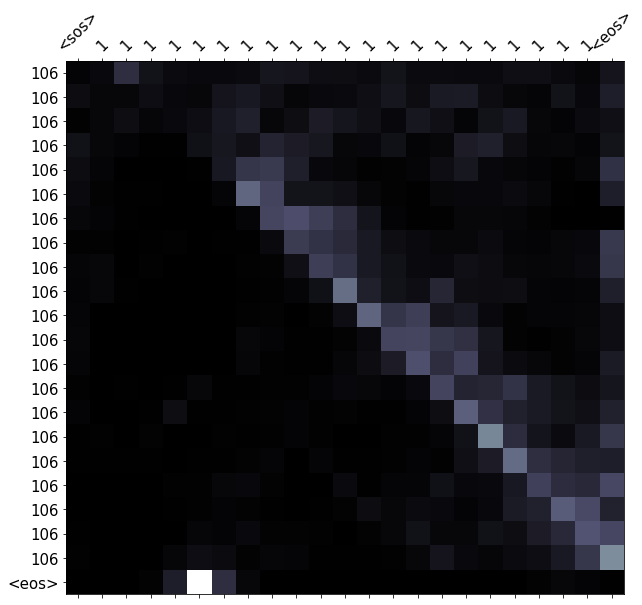

In [26]:
display_attention(src, translation, attention)

Translations from the training set could simply be memorized by the model. So it's only fair we look at translations from the validation and testing set too.

Starting with the validation set, let's get an example.

In [27]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['Sensor']
trg = vars(valid_data.examples[example_idx])['Activity']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
trg = ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32']


Then let's generate our translation and view the attention.

Here, we can see the translation is the same except for swapping *female* with *woman*.

predicted trg = ['106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '106', '<eos>']


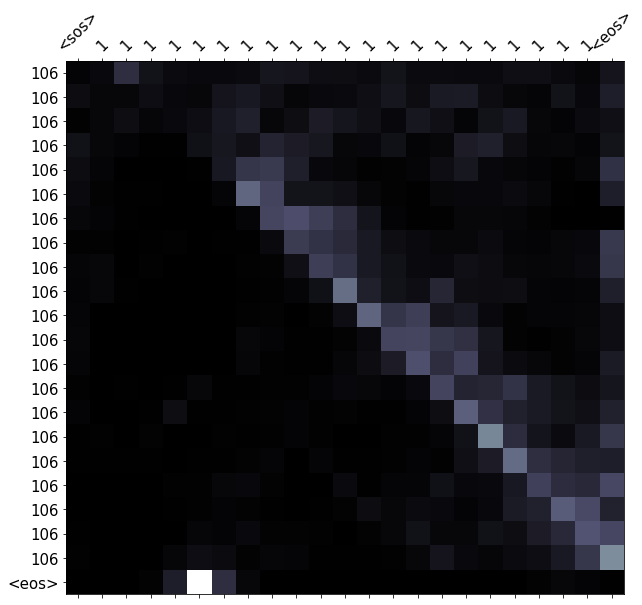

In [28]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

Finally, let's get an example from the test set.

In [29]:
example_idx = 18

src = vars(test_data.examples[example_idx])['Sensor']
trg = vars(test_data.examples[example_idx])['Activity']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['1', '1', '30', '1514', '1515', '139', '139', '186', '187', '188', '248', '1516', '1517', '18', '1', '1', '1', '1', '1', '1', '1']
trg = ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32']


Again, it produces a slightly different translation than target, a more literal version of the source sentence. It swaps *mountain climbing* for *climbing on a mountain*.

predicted trg = ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '<eos>']


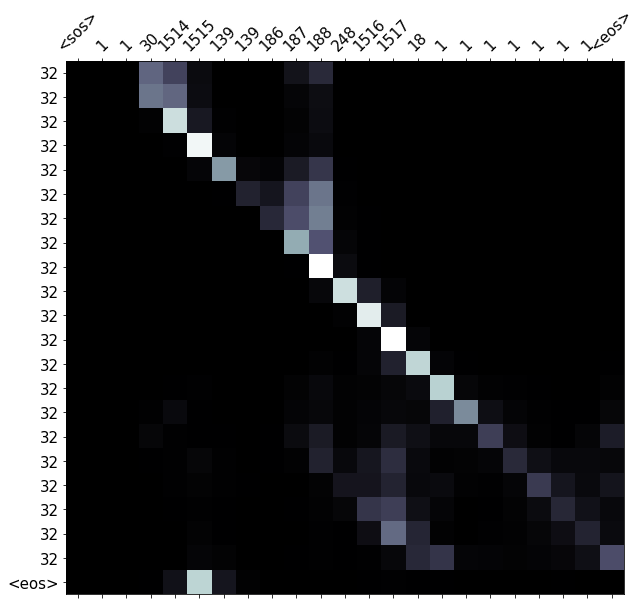

In [30]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

We get a BLEU of around 29. If we compare it to the paper that the attention model is attempting to replicate, they achieve a BLEU score of 26.75. This is similar to our score, however they are using a completely different dataset and their model size is much larger - 1000 hidden dimensions which takes 4 days to train! - so we cannot really compare against that either.

This number isn't really interpretable, we can't really say much about it. The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the **higher** BLEU score is "better".

## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [78]:
source_sents = []
target_sents = []
for datum in train_data:
    src = vars(datum)['Sensor']
    trg = vars(datum)['Activity']
    source_sents.append(src)
    target_sents.append(trg)
for datum in valid_data:
    src = vars(datum)['Sensor']
    trg = vars(datum)['Activity']
    source_sents.append(src)
    target_sents.append(trg)
for datum in test_data:
    src = vars(datum)['Sensor']
    trg = vars(datum)['Activity']
    source_sents.append(src)
    target_sents.append(trg)
print(len(source_sents))
print(len(target_sents))

23766
23766


In [79]:
source_to_target = {}
for i, source in enumerate(source_sents):
  if tuple(source) in source_to_target:
      source_to_target[tuple(source)].append(target_sents[i])
  else:
      source_to_target[tuple(source)] = [target_sents[i]]

[['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32'], ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32'], ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32'], ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32'], ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32'], ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32'], ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32'], ['32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', 

In [80]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):   
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['Sensor']
        trg = vars(datum)['Activity']
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        # print("A:", pred_trg)
        # print("B:", trg)
        pred_trgs.append(pred_trg)
        trg = source_to_target[tuple(src)]
        trgs.append(trg)
        # print(pred_trgs,trgs)
        # break
    return bleu_score(pred_trgs, trgs)

In [81]:
bleu_score_a = calculate_bleu_accuracy(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score_a*100:.2f}')

accuracy_a = calculate_accuracy()

BLEU score = 91.60


In [89]:
source_sents_valid = []
target_sents_valid = []
source_sents_test = []
target_sents_test = []
source_sents_train = []
target_sents_train = []
for datum in valid_data:
    src = vars(datum)['Sensor']
    trg = vars(datum)['Activity']
    source_sents_valid.append(src)
    target_sents_valid.append(trg)
for datum in test_data:
    src = vars(datum)['Sensor']
    trg = vars(datum)['Activity']
    source_sents_test.append(src)
    target_sents_test.append(trg)
for datum in train_data:
    src = vars(datum)['Sensor']
    trg = vars(datum)['Activity']
    source_sents_train.append(src)
    target_sents_train.append(trg)

In [90]:
def accuracy(source_sents_inp, target_sents_inp, src_field, trg_field, model, device, max_len = 50):   
    total = 0.0
    for i, src in enumerate(source_sents_inp):
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        trg = target_sents_inp[i]
        total += 1.0 if tuple(pred_trg) == tuple(trg) else 0.0
    return total /len(source_sents_inp)

In [91]:
accuracy(source_sents_train, target_sents_train, SRC, TRG, model, device)

0.7372600035887313